Aim: initial size = 10, find setting AL is superior than IID, use default lr
<br> 
Try: (1) n = 1, mini-batches

In [1]:
import numpy as np
import torch
from torch import nn, distributions
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets
from dataclasses import dataclass

In [2]:
mnist_train = datasets.MNIST("../data", train=True, download=True, transform=ToTensor())
mnist_test  = datasets.MNIST("../data", train=False,download=True, transform=ToTensor())
traindataloader = DataLoader(mnist_train, shuffle=True, batch_size=60000)
testdataloader  = DataLoader(mnist_test , shuffle=True, batch_size=10000)
X_train, y_train = next(iter(traindataloader))
X_test , y_test  = next(iter(testdataloader))

X_train = X_train.reshape(60000, -1)
X_test = X_test.reshape(10000, -1)

device = "cuda" if torch.cuda.is_available() else "cpu"

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# sepeate train data into (1) initial, (2) pool
initial_idx = np.array([],dtype=int)
for i in range(10):
    idx = np.random.choice(np.where(y_train==i)[0], size=1, replace=False)
    initial_idx = np.concatenate((initial_idx, idx))

X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [ ]:
# BALD Acquisition function (incomplete sampling in paper, not in use)
def bald(model_A, model_S1, model_S2, X, n_instances, T = 100):
  
    random_subset = np.random.choice(range(len(X)), size=len(X), replace=False)
    with torch.no_grad():
        x = X[random_subset].to(device)
        outputs = np.stack([torch.exp(model_A(x)).detach().cpu().numpy() for t in range(T)])

    pc = outputs.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0) 
    acquisition = H - E_H
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]

    score_A = acquisition[query_idx]
    
    #---------------- score for successors:
    with torch.no_grad():
        output_S1 = np.stack([torch.exp(model_S1(X[query_idx].to(device))).detach().cpu().numpy() for t in range(T)])
        output_S2 = np.stack([torch.exp(model_S2(X[query_idx].to(device))).detach().cpu().numpy() for t in range(T)])

    pc = output_S1.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(output_S1 * np.log(output_S1 + 1e-10), axis=-1), axis=0) 
    score_S1 = H - E_H

    pc = output_S2.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(output_S2 * np.log(output_S2 + 1e-10), axis=-1), axis=0) 
    score_S2 = H - E_H

    return (query_idx, score_A, score_S1, score_S2) 

In [4]:
# BALD Acquisition function (in use)
def bald(model_A, model_S1, model_S2, X, n_instances, T = 100):
    with torch.no_grad():
        x = X.to(device)
        outputs = np.stack([torch.exp(model_A(x, eval = True)).detach().cpu().numpy() for t in range(T)])

    pc = outputs.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0) 
    acquisition = H - E_H
    query_idx = (-acquisition).argsort()[:n_instances]

    score_A = acquisition[query_idx]
    
    #---------------- score for successors:
    with torch.no_grad():
        output_S1 = np.stack([torch.exp(model_S1(X[query_idx].to(device), eval = True)).detach().cpu().numpy() for t in range(T)])
        output_S2 = np.stack([torch.exp(model_S2(X[query_idx].to(device), eval = True)).detach().cpu().numpy() for t in range(T)])

    pc = output_S1.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(output_S1 * np.log(output_S1 + 1e-10), axis=-1), axis=0) 
    score_S1 = H - E_H

    pc = output_S2.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(output_S2 * np.log(output_S2 + 1e-10), axis=-1), axis=0) 
    score_S2 = H - E_H

    return (query_idx, score_A, score_S1, score_S2) 

In [5]:
# IID acquistion:
def iid_acq(model_A, model_S1, model_S2, X, n_instances, T = 100):

    query_idx = np.random.choice(range(len(X)), size=n_instances, replace=False)
    with torch.no_grad():
        x = X[query_idx].to(device)
        outputs = np.stack([torch.exp(model_A(x, eval = True)).detach().cpu().numpy() for t in range(T)])
        output_S1 = np.stack([torch.exp(model_S1(x, eval = True)).detach().cpu().numpy() for t in range(T)])
        output_S2 = np.stack([torch.exp(model_S2(x, eval = True)).detach().cpu().numpy() for t in range(T)])

    pc = outputs.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0) 
    score_A = H - E_H
    
    #---------------- score for the other 2 models:
    pc = output_S1.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(output_S1 * np.log(output_S1 + 1e-10), axis=-1), axis=0) 
    score_S1 = H - E_H

    pc = output_S2.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(output_S2 * np.log(output_S2 + 1e-10), axis=-1), axis=0) 
    score_S2 = H - E_H

    return (query_idx, score_A, score_S1, score_S2) 

In [6]:
def active_learning_procedure(X_test,
                              y_test,
                              X_pool,
                              y_pool,
                              X_initial,
                              y_initial,
                              n_queries=100, 
                              n_instances=1,
                              sample_strategy = 'bald',
                              Model_A = 1,
                              Model_S1 = 2,
                              Model_S2 = 3):

    pool_idx = list()
    x_train_sample = X_initial
    y_train_sample = y_initial
    train_loader = DataLoader(list(zip(x_train_sample,  y_train_sample)), 
                      shuffle=True, batch_size = 10)

    #valid_idx = np.random.randint(0, len(y_pool), len(x_train_sample))
    #x_valid = X_pool[valid_idx]
    #y_valid = y_pool[valid_idx]

    #valid_loader = DataLoader(list(zip(x_valid,  y_valid)), 
    #                  shuffle=False, batch_size = len(x_valid))

    #----- Model A --------------------------
    if (Model_A==1):
        A = Model1(784, 10, n_batch = len(train_loader)).to(device)
        early_epoch = 100
    elif (Model_A ==2 ):
        A = Model2(784, 392, 10, n_batch = len(train_loader)).to(device)
        early_epoch = 200
    elif (Model_A == 3):
        A = Model3(784, [392, 196], 10, n_batch = len(train_loader)).to(device)
        early_epoch = 500
    else:
        print('Invalid option for Model_A')
        return
    A.reset_bs()
    optim0 = torch.optim.Adam(A.parameters(), lr=0.001)
    _, acc = train(A, optim0, 1000, train_loader, X_test, y_test, early_epoch, verbose = False)
    acquisition_hist  = [acc]


    #----- Model S --------------------------
    if (Model_S1 == 1):
        S1 = Model1(784, 10, n_batch = len(train_loader)).to(device)
        early_epoch = 100
    elif (Model_S1 ==2):
        S1 = Model2(784, 392, 10, n_batch = len(train_loader)).to(device)
        early_epoch = 200
    else:
        print('Invalid option for Model_S1')
        return
    S1.reset_bs()
    optim1 = torch.optim.Adam(S1.parameters(), lr=0.001)
    _, acc = train(S1, optim1, 1000, train_loader, X_test, y_test, early_epoch, verbose = False)
    successor1_hist = [acc]

    if (Model_S2 == 1):
        S2 = Model1(784, 10, n_batch = len(train_loader)).to(device)
        early_epoch = 100
    elif (Model_S2 ==3):
        S2 = Model3(784, [392, 196], 10, n_batch = len(train_loader)).to(device)
        early_epoch = 500
    else:
        print('Invalid option for Model_A')
        return
    S2.reset_bs()  
    optim2 = torch.optim.Adam(S2.parameters(), lr=0.001)
    _, acc = train(S2, optim2, 1000,  train_loader, X_test, y_test, early_epoch, verbose = False)
    successor2_hist = [acc]

    scores = list()

    for index in range(n_queries):
        # for incomplete sampling (paper):
        #query_idx = np.concatenate([bald(A, X_pool) for n in range(n_instances)])

        # for complete set sampling:
        if (sample_strategy  == 'bald'):
            query_idx, score_A, score_S1, score_S2 = bald(A, S1, S2, X_pool, n_instances)
        elif (sample_strategy == 'iid'):
            query_idx, score_A, score_S1, score_S2 = iid_acq(A, S1, S2, X_pool, n_instances)
        else:
            print('Unexpected sampling strategy')
            break
        
        # record scores:
        scores.append(np.vstack((score_A, score_S1, score_S2)))

        x_train_sample = torch.vstack((x_train_sample, X_pool[query_idx]))
        y_train_sample = torch.cat((y_train_sample,y_pool[query_idx]))
        train_loader = DataLoader(list(zip(x_train_sample,  y_train_sample)), 
                      shuffle=True, batch_size = 10)

        #valid_idx = np.random.randint(0, len(y_pool), len(x_train_sample))
        #x_valid = X_pool[valid_idx]
        #y_valid = y_pool[valid_idx]
        #valid_loader = DataLoader(list(zip(x_valid,  y_valid)), 
        #              shuffle=False, batch_size = len(x_valid))

        # model A:
        if (Model_A==1):
            A = Model1(784, 10, n_batch = len(train_loader)).to(device)
            early_epoch = 100
        elif (Model_A ==2 ):
            A = Model2(784, 392, 10, n_batch = len(train_loader)).to(device)
            early_epoch = 200
        elif (Model_A == 3):
            A = Model3(784, [392, 196], 10, n_batch = len(train_loader)).to(device)
            early_epoch = 500
        else:
            print('Invalid option for Model_A')
            return
        A.reset_bs()
        optim0 = torch.optim.Adam(A.parameters(), lr=0.001)
        _, acc = train(A, optim0, 1000, train_loader, X_test, y_test, early_epoch, verbose = False)
        acquisition_hist.append(acc)

        # model S:
        if (Model_S1 == 1):
            S1 = Model1(784, 10, n_batch = len(train_loader)).to(device)
            early_epoch = 100
        elif (Model_S1 ==2):
            S1 = Model2(784, 392, 10, n_batch = len(train_loader)).to(device)
            early_epoch = 200
        else:
            print('Invalid option for Model_S1')
            return
        S1.reset_bs()
        optim1 = torch.optim.Adam(S1.parameters(), lr=0.001)
        _, acc = train(S1, optim1, 1000,  train_loader, X_test, y_test, early_epoch, verbose = False)
        successor1_hist.append(acc)

        if (Model_S2 == 1):
            S2 = Model1(784, 10, n_batch = len(train_loader)).to(device)
            early_epoch = 100
        elif (Model_S2 ==3):
            S2 = Model3(784, [392, 196], 10, n_batch = len(train_loader)).to(device)
            early_epoch = 500
        else:
            print('Invalid option for Model_A')
            return  
        S2.reset_bs()
        optim2 = torch.optim.Adam(S2.parameters(), lr=0.001)
        _, acc = train(S2, optim2, 1000, train_loader, X_test, y_test, early_epoch, verbose = False)
        successor2_hist.append(acc)

        
        # delete queried data from pool:
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

        print('Query {n}: {acc:0.4f}(Model A)    |     {acc_s1:0.4f}(Model S1) - {acc_s2:0.4f}(Model S2) '.format(n=index + 1, 
                                                                                                                  acc=acquisition_hist[-1], 
                                                                                                                  acc_s1 = successor1_hist[-1], 
                                                                                                                  acc_s2 = successor2_hist[-1]))     
        pool_idx.append(query_idx)
    return(acquisition_hist, successor1_hist, successor2_hist, scores, pool_idx)

In [7]:
class LinearVariational(nn.Module):
    def __init__(self, in_features, out_features, loss_accumulator, batch_num, n_batch, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.include_bias = bias        
        self.loss_accumulator = loss_accumulator
        self.n_batch = n_batch
        self.batch_num = batch_num
        
        if getattr(loss_accumulator, 'accumulated_kl_div', None) is None:
            loss_accumulator.accumulated_kl_div = 0
        if getattr(batch_num, 'accumulated_bs', None) is None:
            batch_num.accumulated_bs = 0

        # mean:
        self.w_mu = nn.Parameter(
            torch.FloatTensor(in_features, out_features).normal_(mean=0, std=0.001)
        )
         
        # variance log(1 + exp(p))◦ eps:
        self.w_p = nn.Parameter(
            torch.FloatTensor(in_features, out_features).normal_(mean=-2.5, std=0.001)
        )
        if self.include_bias:
            self.b_mu = nn.Parameter(
                torch.zeros(out_features)
            )
            self.b_p = nn.Parameter(
                torch.zeros(out_features)
            )
        
    def reparameterize(self, mu, p):
        sigma = torch.log(1 + torch.exp(p)) 
        eps = torch.randn_like(sigma)
        return mu + (eps * sigma)
    
    def kl_divergence(self, z, mu_theta, p_theta, batch_num, prior_sd=1):
        log_prior = distributions.Normal(0, prior_sd).log_prob(z) 
        log_p_q = distributions.Normal(mu_theta, torch.log(1 + torch.exp(p_theta))).log_prob(z) 
        # weighting for each batch
        weights =  np.power(2,self.n_batch - batch_num) /  (np.power(2,self.n_batch)-1) 

        #print('batch_num {}: weights {}'.format(batch_num, weights))
        return (log_p_q - log_prior).mean() * weights

    def forward(self, x):
        w = self.reparameterize(self.w_mu, self.w_p)
        
        if self.include_bias:
            b = self.reparameterize(self.b_mu, self.b_p)
        else:
            b = 0
            
        z = x @ w + b
        
        if (self.batch_num.clip == False):
            self.batch_num.accumulated_bs += 1
        self.loss_accumulator.accumulated_kl_div += self.kl_divergence(w, 
                                                             self.w_mu,
                                                             self.w_p,
                                                             self.batch_num.accumulated_bs
                                                             )
        if self.include_bias:
            self.loss_accumulator.accumulated_kl_div += self.kl_divergence(b, 
                                                                 self.b_mu, 
                                                                 self.b_p,
                                                                 self.batch_num.accumulated_bs
                                                                 )
        return z


@dataclass
class KL:
    accumulated_kl_div = 0
class BS:
    accumulated_bs = 0
    clip = False

def det_loss(y, y_pred, model):
    reconstruction_error = F.nll_loss(y_pred, y,reduction="mean")
    kl = model.accumulated_kl_div
    #model.reset_kl_div() # reset fo each batch
    #model.reset_bs()
    #print('rec: {} | kl: {}'.format(reconstruction_error, kl))
    return reconstruction_error + kl



In [8]:
class Model1(nn.Module):
    def __init__(self, in_size, out_size, n_batch):
        super().__init__()
        self.kl_loss = KL
        self.bs_num = BS

        self.var = LinearVariational(in_size, out_size, self.kl_loss, self.bs_num, n_batch)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim = 1)
        
        self.layers = nn.Sequential(
            LinearVariational(in_size, out_size, self.kl_loss, self.bs_num, n_batch),
            nn.LogSoftmax(dim = 1)
        )
    
    @property
    def accumulated_kl_div(self):
        return self.kl_loss.accumulated_kl_div
    
    def reset_kl_div(self):
        self.kl_loss.accumulated_kl_div = 0

    def accumulated_bs(self):
        return self.bs_num.accumulated_bs
    
    def reset_bs(self):
        self.bs_num.accumulated_bs = 0
    
    def clip_bs(self, clip = True):
        self.bs_num.clip = clip
    
    def set_bs(self, val):
        self.bs_num.accumulated_bs = val
            
    def forward(self, x, eval = False):
        if eval:
            Model1.set_bs(self, val = 1)
            Model1.clip_bs(self, clip = True)
        else:
            Model1.clip_bs(self, clip = False)
        out = self.var(x)
        out = self.log_softmax(out)
        return out

class Model2(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, n_batch):
        super().__init__()
        self.kl_loss = KL
        self.bs_num = BS
        
        self.var1 = LinearVariational(in_size, hidden_size, self.kl_loss, self.bs_num, n_batch)
        self.var2 = LinearVariational(hidden_size, out_size, self.kl_loss, self.bs_num, n_batch)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim = 1)


    @property
    def accumulated_kl_div(self):
        return self.kl_loss.accumulated_kl_div
    
    def reset_kl_div(self):
        self.kl_loss.accumulated_kl_div = 0

    def accumulated_bs(self):
        return self.bs_num.accumulated_bs
    
    def reset_bs(self):
        self.bs_num.accumulated_bs = 0

    def clip_bs(self, clip = True):
        self.bs_num.clip = clip
    
    def set_bs(self, val):
        self.bs_num.accumulated_bs = val
            
    def forward(self, x, eval = False):
        if eval:
            Model2.set_bs(self, val = 1)
            Model2.clip_bs(self, clip = True)
        else:
            Model2.clip_bs(self, clip = False)
        out = self.var1(x)   
        out = self.relu(out)

        Model2.clip_bs(self)

        out = self.var2(out)
        out = self.log_softmax(out)


        return out

class Model3(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, n_batch):
        super().__init__()
        self.kl_loss = KL
        self.bs_num = BS

        self.var1 = LinearVariational(in_size, hidden_size[0], self.kl_loss, self.bs_num, n_batch)
        self.var2 = LinearVariational(hidden_size[0], hidden_size[1], self.kl_loss, self.bs_num, n_batch)
        self.var3 = LinearVariational(hidden_size[1], out_size, self.kl_loss, self.bs_num, n_batch)

        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim = 1)

    
    @property
    def accumulated_kl_div(self):
        return self.kl_loss.accumulated_kl_div
    
    def reset_kl_div(self):
        self.kl_loss.accumulated_kl_div = 0

    def accumulated_bs(self):
        return self.bs_num.accumulated_bs
    
    def reset_bs(self):
        self.bs_num.accumulated_bs = 0

    def clip_bs(self, clip = True):
        self.bs_num.clip = clip

    def set_bs(self, val):
        self.bs_num.accumulated_bs = val
            
    def forward(self, x, eval = False):
        if eval:
            Model3.set_bs(self, val = 1)
            Model3.clip_bs(self, clip = True)
        else:
            Model3.clip_bs(self, clip = False)
        out = self.var1(x)
        out = self.relu(out)

        Model3.clip_bs(self)
        out = self.var2(out)
        out = self.relu(out)

        out = self.var3(out)
        out = self.log_softmax(out)
        return out

In [56]:
# Train
def train(model, optimizer, num_epoch,
          train_loader, 
          X_test, y_test, early_epoch,
          verbose = False):
    train_ls = list()
    #valid_ls = list()
    test_acc = 0
    train_kl = list()

    for epoch in range(num_epoch):
        ls = 0
        kl = 0
        num_correct = 0
        data_num = 0

        model.train()
        for batch_num, (x, y) in enumerate(train_loader):
            #print('in train : batch_num{}'.format(batch_num))

            x = x.to(device)
            y = y.to(device)

            # forward:
            y_pred = model(x, eval = False)
            loss = det_loss(y, y_pred, model)
            kl += model.accumulated_kl_div
            model.reset_kl_div()
            ls += loss.item()

            # backward:
            optimizer.zero_grad() # remove grad from forward prop
            loss.backward()

            # update gradient:
            optimizer.step()

            # accuracy:
            #_, pred = torch.max(y_pred,1)
            #num_correct += (pred == y).sum().item()

            data_num += len(y)
        model.reset_bs()

        ls = ls/data_num
        #print('valid:')
        #val_ls = eval_ls(model, valid_loader)
        #weights = np.power(2, len(train_loader)-1) / (np.power(2, len(train_loader)) - 1 )
        #weights = 1

        #val_ls = val_ls/weights
        #model.reset_bs()
        #if verbose:
        #    print(epoch+1)
        #    print(f'\tLoss: {ls:.4f}(train)\t|\tLoss: {val_ls:.4f}(valid)')
        train_ls.append(ls)
        #valid_ls.append(val_ls)
        train_kl.append(kl/data_num)

        # access early stopping:
        #trigger = (np.array(train_ls[epoch-50:]) < np.array(valid_ls[epoch-50:])).sum()/500
        #if (trigger > 0.5):
        #    if verbose:
        #        print('Epoch {} : Early Stopping - past 50 epochs half val_ls > train_ls'.format(epoch))
        #    test_acc = eval_acc(model, X_test, y_test)
        #    break

        if ((epoch > early_epoch) & (epoch % 10 == 0)):
            mean_1 = np.mean(train_ls[epoch-60:epoch-10])
            mean_2 = np.mean(train_ls[epoch-50:])
            if (mean_1 - mean_2 < 1e-3):
                print(epoch)
                test_acc = eval_acc(model, X_test, y_test)
                break

        if (epoch == num_epoch-1):
            print(epoch)
            test_acc = eval_acc(model, X_test, y_test)
        

    return(train_ls, test_acc)


def eval_ls(model, loader):
    ls = 0
    data_num = 0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x, eval = True)
            loss = det_loss(y, y_pred, model)
            ls += loss.item()

            data_num += len(y)
        model.reset_bs()
    model.train()
    return ls/data_num

def eval_acc(model, test_x, test_y):

    y_sample = np.stack([torch.exp(model(test_x.to(device), eval = True)).detach().cpu().numpy() for t in range(100)])

    y_pred = y_sample.mean(axis = 0).argmax(axis = 1)

    #y_sample = model(test_x.to(device)).detach().cpu().numpy()
    #y_pred = y_sample.argmax(axis = 1)
    acc = np.equal(y_pred, test_y).sum().item()/len(test_y)
    return acc


In [57]:
# A1 BALD
acquisition_hist, successor1_hist, successor2_hist, scores, pool_idx = active_learning_procedure(
                                                                                X_test,
                                                                                y_test,
                                                                                X_pool,
                                                                                y_pool,
                                                                                X_initial,
                                                                                y_initial,
                                                                                n_queries = 20,
                                                                                n_instances = 1,
                                                                                Model_A = 1, Model_S1 = 2, Model_S2 = 3)
with open('res_bald_A1.npy', 'wb') as f:
    np.save(f, acquisition_hist)
    np.save(f, successor1_hist)
    np.save(f, successor2_hist)
    np.save(f, scores)

from google.colab import files
files.download('res_bald_A1.npy')


150
310
630
190
270
540
Query 1: 0.3602(Model A)    |     0.3733(Model S1) - 0.3587(Model S2) 
220
320
590
Query 2: 0.3877(Model A)    |     0.3556(Model S1) - 0.3267(Model S2) 
300
300
520
Query 3: 0.4327(Model A)    |     0.4047(Model S1) - 0.3973(Model S2) 
250
290
540
Query 4: 0.3980(Model A)    |     0.3854(Model S1) - 0.3717(Model S2) 
260
290
600
Query 5: 0.4241(Model A)    |     0.4265(Model S1) - 0.4390(Model S2) 
190
270
560
Query 6: 0.4583(Model A)    |     0.4394(Model S1) - 0.4065(Model S2) 
190
330
560
Query 7: 0.4757(Model A)    |     0.4527(Model S1) - 0.4291(Model S2) 
190
270
540
Query 8: 0.4841(Model A)    |     0.4690(Model S1) - 0.4822(Model S2) 
230
280
550
Query 9: 0.5131(Model A)    |     0.5081(Model S1) - 0.4758(Model S2) 
210
310
550
Query 10: 0.5444(Model A)    |     0.5562(Model S1) - 0.4918(Model S2) 
190
330
590
Query 11: 0.5523(Model A)    |     0.5178(Model S1) - 0.4941(Model S2) 
220
270
510
Query 12: 0.5669(Model A)    |     0.5523(Model S1) - 0.5363(

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
#iid
acquisition_hist, successor1_hist, successor2_hist, scores, pool_idx = active_learning_procedure(
                                                                                X_test,
                                                                                y_test,
                                                                                X_pool,
                                                                                y_pool,
                                                                                X_initial,
                                                                                y_initial,
                                                                                n_queries = 20,
                                                                                n_instances = 1,
                                                                                sample_strategy = 'iid',
                                                                                Model_A = 1, Model_S1 = 2, Model_S2 = 3)
with open('res_iid_A1.npy', 'wb') as f:
    np.save(f, acquisition_hist)
    np.save(f, successor1_hist)
    np.save(f, successor2_hist)
    np.save(f, scores)

from google.colab import files
files.download('res_iid_A1.npy')

180
300
690
360
300
670
Query 1: 0.4327(Model A)    |     0.4139(Model S1) - 0.4288(Model S2) 
220
290
580
Query 2: 0.4646(Model A)    |     0.4461(Model S1) - 0.4391(Model S2) 
290
300
600
Query 3: 0.4580(Model A)    |     0.4526(Model S1) - 0.4335(Model S2) 
220
280
510
Query 4: 0.4694(Model A)    |     0.4639(Model S1) - 0.4503(Model S2) 
230
290
510
Query 5: 0.4883(Model A)    |     0.4873(Model S1) - 0.4556(Model S2) 
200
310
540
Query 6: 0.4791(Model A)    |     0.5014(Model S1) - 0.4715(Model S2) 
220
290
540
Query 7: 0.4644(Model A)    |     0.5007(Model S1) - 0.4725(Model S2) 
180
280
510
Query 8: 0.4843(Model A)    |     0.5075(Model S1) - 0.4653(Model S2) 
190
260
540
Query 9: 0.4997(Model A)    |     0.5051(Model S1) - 0.5159(Model S2) 
210
290
560
Query 10: 0.5022(Model A)    |     0.5087(Model S1) - 0.5051(Model S2) 
230
310
530
Query 11: 0.4844(Model A)    |     0.5234(Model S1) - 0.5046(Model S2) 
220
260
520
Query 12: 0.5264(Model A)    |     0.5239(Model S1) - 0.5190(

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
# A2 BALD
acquisition_hist, successor1_hist, successor2_hist, scores, pool_idx = active_learning_procedure(
                                                                                X_test,
                                                                                y_test,
                                                                                X_pool,
                                                                                y_pool,
                                                                                X_initial,
                                                                                y_initial,
                                                                                n_queries = 20,
                                                                                n_instances = 1,
                                                                                Model_A = 2, Model_S1 = 1, Model_S2 = 3)
with open('res_bald_A2.npy', 'wb') as f:
    np.save(f, acquisition_hist)
    np.save(f, successor1_hist)
    np.save(f, successor2_hist)
    np.save(f, scores)

from google.colab import files
files.download('res_bald_A2.npy')

360
190
760
300
230
630
Query 1: 0.4070(Model A)    |     0.4236(Model S1) - 0.3981(Model S2) 
380
250
600
Query 2: 0.4335(Model A)    |     0.4388(Model S1) - 0.4223(Model S2) 
270
280
540
Query 3: 0.4675(Model A)    |     0.4624(Model S1) - 0.4293(Model S2) 
270
260
540
Query 4: 0.4435(Model A)    |     0.4559(Model S1) - 0.4611(Model S2) 
300
210
560
Query 5: 0.4541(Model A)    |     0.4362(Model S1) - 0.4318(Model S2) 
310
210
550
Query 6: 0.4509(Model A)    |     0.4473(Model S1) - 0.4350(Model S2) 
320
230
540
Query 7: 0.4845(Model A)    |     0.4825(Model S1) - 0.4130(Model S2) 
320
210
630
Query 8: 0.4812(Model A)    |     0.4773(Model S1) - 0.4625(Model S2) 
340
210
600
Query 9: 0.4882(Model A)    |     0.4725(Model S1) - 0.4898(Model S2) 
300
180
600
Query 10: 0.5113(Model A)    |     0.4943(Model S1) - 0.4759(Model S2) 
320
260
620
Query 11: 0.5000(Model A)    |     0.5198(Model S1) - 0.5159(Model S2) 
320
200
570
Query 12: 0.5079(Model A)    |     0.5283(Model S1) - 0.5036(

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# A3 BALD
acquisition_hist, successor1_hist, successor2_hist, scores, pool_idx = active_learning_procedure(
                                                                                X_test,
                                                                                y_test,
                                                                                X_pool,
                                                                                y_pool,
                                                                                X_initial,
                                                                                y_initial,
                                                                                n_queries = 20,
                                                                                n_instances = 1,
                                                                                Model_A = 3, Model_S1 = 2, Model_S2 = 1)
with open('res_bald_A3.npy', 'wb') as f:
    np.save(f, acquisition_hist)
    np.save(f, successor1_hist)
    np.save(f, successor2_hist)
    np.save(f, scores)

from google.colab import files
files.download('res_bald_A3.npy')


640
330
180
510
360
260
Query 1: 0.3558(Model A)    |     0.4009(Model S1) - 0.3929(Model S2) 
530
420
220
Query 2: 0.4120(Model A)    |     0.4406(Model S1) - 0.4317(Model S2) 
650
310
240
Query 3: 0.4170(Model A)    |     0.4385(Model S1) - 0.4310(Model S2) 
570
310
230
Query 4: 0.3832(Model A)    |     0.4222(Model S1) - 0.4231(Model S2) 
530
360
260
Query 5: 0.4159(Model A)    |     0.4419(Model S1) - 0.4422(Model S2) 
630
380
220
Query 6: 0.4175(Model A)    |     0.4190(Model S1) - 0.3977(Model S2) 
590
350
230
Query 7: 0.4134(Model A)    |     0.4146(Model S1) - 0.4071(Model S2) 
520
300
190
Query 8: 0.4665(Model A)    |     0.3887(Model S1) - 0.4380(Model S2) 
590
310
200
Query 9: 0.4571(Model A)    |     0.4446(Model S1) - 0.4413(Model S2) 
620
300
230
Query 10: 0.4423(Model A)    |     0.4393(Model S1) - 0.4513(Model S2) 
630
310
240
Query 11: 0.4638(Model A)    |     0.4941(Model S1) - 0.4823(Model S2) 
570
320
260
Query 12: 0.5464(Model A)    |     0.4987(Model S1) - 0.5225(

## test convergence, visulaising training loss:

In [10]:
train_loader = DataLoader(list(zip(X_initial,  y_initial)), 
                      shuffle=True, batch_size = 10)
valid_loader = DataLoader(list(zip(X_pool[:1000],  y_pool[:1000])), 
                      shuffle=False, batch_size = 1000)

In [ ]:
train_x = np.vstack((X_initial, X_train[:50]))
train_y = np.hstack((y_initial, y_train[:50]))


In [52]:
#m = Model3(784, [392, 196], 10, n_batch = len(train_loader)).to(device)
m = Model2(784, 392, 10, n_batch = len(train_loader)).to(device)
#m = Model1(784, 10, n_batch = len(train_loader)).to(device)
optim = torch.optim.Adam(m.parameters(), lr=0.001)
m.reset_bs()


In [53]:
train_ls, test_acc, train_kl = train(m, optim, 1000, 
                              train_loader, 
                              X_test, y_test,
                              early_epoch = 200,
                              verbose = True)

300


In [54]:
test_acc

0.3953

In [51]:
for epoch in range(len(train_ls)):
    fake_ls = train_ls[:epoch+1]

    if ((epoch > 500) & (epoch % 10 == 0)):
        mean_1 = np.mean(fake_ls[epoch-60:epoch-10])
        mean_2 = np.mean(fake_ls[epoch-50:])
        print('epoch {}: {}'.format(epoch, mean_1-mean_2))
        if (mean_1 - mean_2 < 1e-3):
            print(epoch)
            #break



epoch 510: 0.014064455051048141
epoch 520: 0.009687232316709093
epoch 530: 0.012613160769144538
epoch 540: 0.006959145901249908
epoch 550: 0.012060129502240224
epoch 560: 0.010074624828264045
epoch 570: 0.011348340614169339
epoch 580: 0.007967644728866241
epoch 590: 0.010832660188861865
epoch 600: 0.008807213128781854
epoch 610: 0.004506147216348011
epoch 620: 0.0050377848008100745
epoch 630: 0.002073962660396722
epoch 640: 0.00272337793836408
epoch 650: 0.0032731574750414216
epoch 660: 0.00396108776915316
epoch 670: -0.00021134941250688932
670


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

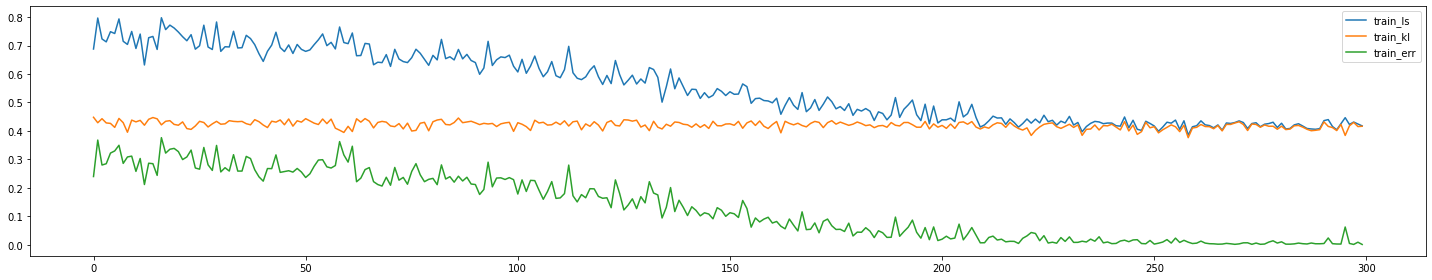

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize = (20,4))

epoch = 300
axs.plot(range(epoch), train_ls[1:], label = 'train_ls')
#axs.plot(range(epoch), valid_ls[1:], label = 'valid_ls')
err = [a_i - b_i for a_i, b_i in zip(train_ls, train_kl)]
axs.plot(range(epoch), train_kl[1:], label = 'train_kl')
axs.plot(range(epoch), err[1:], label = 'train_err')
axs.legend()

#plt.savefig('training_loss.png', dpi=300, bbox_inches='tight')
#from google.colab import files
#files.download('training_loss.png')




In [ ]:
import copy

In [ ]:
# check stopping creterion for bald: (extend training epoch)
train_x = copy.deepcopy(X_initial)
train_y = copy.deepcopy(y_initial)

pool_x = copy.deepcopy(X_pool)
pool_y = copy.deepcopy(y_pool)


for query_idx in pool_idx:
    train_x = np.vstack((train_x, pool_x[query_idx]))
    train_y = np.hstack((train_y, pool_y[query_idx]))
    train_loader = DataLoader(list(zip(train_x,  train_y)), 
                      shuffle=True, batch_size = 10)

    pool_x = np.delete(pool_x, query_idx, axis=0)
    pool_y = np.delete(pool_y, query_idx, axis=0)

    #valid_idx = np.random.randint(0, len(pool_y), len(train_x))
    #x_valid = pool_x[valid_idx]
    #y_valid = pool_y[valid_idx]
    #valid_loader = DataLoader(list(zip(x_valid,  y_valid)), 
    #                    shuffle=True, batch_size = len(y_valid))

    m = Model3(784, [392, 196], 10, n_batch = len(train_loader)).to(device)
    #m = Model2(784, 392, 10, n_batch = len(train_loader)).to(device)
    m.reset_bs()
    optim = torch.optim.Adam(m.parameters(), lr=0.001)
    train_ls, test_acc, train_kl = train(m, optim, 1000, 
                              train_loader,
                              X_test, y_test,
                              early_epoch = 500,
                              verbose = True)

    print('data size {}:  acc {}'.format(len(train_x), test_acc))

520
data size 30:  acc 0.5679
510
data size 40:  acc 0.6059
510
data size 50:  acc 0.6017
510
data size 60:  acc 0.6959
510
data size 70:  acc 0.7095
510
data size 80:  acc 0.7284
510
data size 90:  acc 0.712
510
data size 100:  acc 0.7419
510
data size 110:  acc 0.7647
510
data size 120:  acc 0.7422
510
data size 130:  acc 0.7488
510
data size 140:  acc 0.765
510
data size 150:  acc 0.7982
510
data size 160:  acc 0.7743
510
data size 170:  acc 0.7349
510
data size 180:  acc 0.816
510
data size 190:  acc 0.8195
510
data size 200:  acc 0.7952
510
data size 210:  acc 0.831
510
data size 220:  acc 0.8334


In [ ]:
# check stopping creterion for bald: (extend training epoch)
train_x = copy.deepcopy(X_initial)
train_y = copy.deepcopy(y_initial)

pool_x = copy.deepcopy(X_pool)
pool_y = copy.deepcopy(y_pool)


for query_idx in pool_idx[:1]:
    train_x = np.vstack((train_x, pool_x[query_idx]))
    train_y = np.hstack((train_y, pool_y[query_idx]))
    train_loader = DataLoader(list(zip(train_x,  train_y)), 
                      shuffle=True, batch_size = 10)

    pool_x = np.delete(pool_x, query_idx, axis=0)
    pool_y = np.delete(pool_y, query_idx, axis=0)

    #valid_idx = np.random.randint(0, len(pool_y), len(train_x))
    #x_valid = pool_x[valid_idx]
    #y_valid = pool_y[valid_idx]
    #valid_loader = DataLoader(list(zip(x_valid,  y_valid)), 
    #                    shuffle=True, batch_size = len(y_valid))

    m = Model3(784, [392, 196], 10, n_batch = len(train_loader)).to(device)
    #m = Model2(784, 392, 10, n_batch = len(train_loader)).to(device)
    m.reset_bs()
    optim = torch.optim.Adam(m.parameters(), lr=0.001)
    train_ls, test_acc, train_kl = train(m, optim, 1000, 
                              train_loader,
                              X_test, y_test,
                              early_epoch = 1000,
                              verbose = True)

    print('data size {}:  acc {}'.format(len(train_x), test_acc))

999
data size 30:  acc 0.0964
